# Customer Sentiment

## Business Question

Create a model to determine the sentiment of a customer based on his or her tweet.

In [94]:
# Importing packages

import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import matplotlib.pyplot as plt
import string
import re

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

### Twitter Data

The dataset contained 9093 tweets, as well as determinations of what type of emotional sentiment--positive or negative--each tweet might have expressed.  If there was an emotional angle to a tweet, the brand or product that emotion was directed toward was also included in the data.

In [29]:
corpus = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

In [3]:
corpus.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Data Cleaning

In [30]:
# dropping the 1 row with a null tweet

corpus = corpus.dropna(subset = ['tweet_text'])
corpus = corpus.reset_index(drop=True)

In [31]:
# renaming long column names

corpus.rename(columns = {'emotion_in_tweet_is_directed_at': 'emotion_directed_at',
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion_type'}, inplace=True)

In [32]:
corpus['emotion_type'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion_type, dtype: int64

In [33]:
corpus['emotion_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_directed_at, dtype: int64

## Feature Engineering

In order to determine which tweets are directed toward Apple, we create a new numerical column to identify whether the brand is Apple or not.

In [34]:
# create brand lists that include the appropriate brands and products

Apple = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']


In [35]:
# create the numerical categories for brands

def target_brand(emotion_directed_at):
    if emotion_directed_at in Apple:
        return 1
    else:
        return 0

In [36]:
# add the new column

corpus['target_brand'] = corpus['emotion_directed_at'].apply(target_brand)

In [37]:
corpus['target_brand'].value_counts()

0    6683
1    2409
Name: target_brand, dtype: int64

In a new numerical column, we categorize the type of emotion in the tweet as positive, negative, or neutral.  Neutral includes instances where there was no emotion toward a brand or product found or where the evaluator couldn't tell.

In [38]:
# create groups of emotion types

Positive = ['Positive emotion']
Negative = ['Negative emotion']
Neutral = ['No emotion toward brand or product', "I can't tell"]

In [39]:
# create the numerical categories for emotion types

def target_emotion(emotion_type):
    if emotion_type in Positive:
        return 0
    if emotion_type in Negative:
        return 1
    if emotion_type in Neutral:
        return 2
    else:
        return 3

In [40]:
# add the new column

corpus['target_emotion'] = corpus['emotion_type'].apply(target_emotion)

In [41]:
corpus['target_emotion'].value_counts()

2    5544
0    2978
1     570
Name: target_emotion, dtype: int64

In [42]:
# create new dataframe with tweets directed at Apple

df_apple = corpus[(corpus['target_brand'] == 1) & (corpus['target_emotion'] < 2)]
df_apple = df_apple.reset_index(drop=True)
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tweet_text           2337 non-null   object
 1   emotion_directed_at  2337 non-null   object
 2   emotion_type         2337 non-null   object
 3   target_brand         2337 non-null   int64 
 4   target_emotion       2337 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 91.4+ KB


In [43]:
df_apple['target_emotion'].value_counts()

0    1949
1     388
Name: target_emotion, dtype: int64

We can now remove the columns we don't need and work with the tweets and target emotions going forward.

In [44]:
df_apple = df_apple.drop(['emotion_directed_at', 'emotion_type', 'target_brand'], axis =1)

In [45]:
# sanity check

df_apple.head()

,tweet_text,target_emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0
2,@swonderlin Can not wait for #iPad 2 also. The...,0
3,@sxsw I hope this year's festival isn't as cra...,1
4,Beautifully smart and simple idea RT @madebyma...,0


## Natural Language Processing (NLP)

We start with a train test split, placing 80% of the data in the train set and 20% in test.  The tweets are the independent variable, and the target is the emotion.  A negative emotion is 1, positive emotion is 0.

In [46]:
X = df_apple['tweet_text']
y = df_apple['target_emotion']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

### NLP Pre-processing

In [47]:
# adjust the nltk list of stopwords

sw = list(set(stopwords.words('english')) - {'not'})
sw.extend(['sxsw'])

In [48]:
# transform the tags to parts of speech tags for the WordNetLemmatizer

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [49]:
# use function to handle preprocessing steps

def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [50]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [60]:
print(len(token_docs), len(X_train), len(y_train))

1869 1869 1869


In [61]:
# Check for missing values in X_train
missing_values_X_train = [idx for idx, doc in enumerate(X_train) if pd.isnull(doc)]
print(f"Number of missing values in X_train: {len(missing_values_X_train)}")

# Check for missing values in y_train
missing_values_y_train = [idx for idx, label in enumerate(y_train) if pd.isnull(label)]
print(f"Number of missing values in y_train: {len(missing_values_y_train)}")

Number of missing values in X_train: 0
Number of missing values in y_train: 0


In [170]:
# DON'T THINK WE'LL NEED THIS CELL #

#steps = [('token', regex_tokenize),
#         ('lower', remove_cap),
#         ('stopwords', remove_stop_words),
#         ('lemma', lemmatize_doc)]

#pipe = Pipeline(steps)

### NLP Feature Engineering

In [63]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs,
                                          y_train,
                                          test_size=0.2,
                                          random_state=18)

First, we try a Count Vectorizer to get the counts of tokens in each of the tweets.

In [96]:
cv = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw, analyzer='word', ngram_range=(1,2))
X_cv = cv.fit_transform(df_apple.tweet_text)

df_cv = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())

df_cv

,amp,app,apple,apple store,apps,austin,design,ipad,iphone,iphone app,like,link,mention,new,not,people,quot,rt,rt mention,store
0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
384,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
385,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
386,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
# fit_transform vectorizer on the training set

cv = CountVectorizer(ngram_range=(1,2), max_features=1000000)

X_t_cv = cv.fit_transform(X_t)
X_t_cv = pd.DataFrame.sparse.from_spmatrix(X_t_cv)
X_t_cv.columns = sorted(cv.vocabulary_)
X_t_cv.set_index(y_t.index, inplace=True)

In [73]:
X_t_cv

,aapl,aapl know,aapl open,abandon,abandon reality,aber,aber leider,able,able communicate,able get,...,zms,zms mention,zombie,zomg,zomg ipad,zomg mention,zone,zone right,zzzs,zzzs iphone
1431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1079,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# transform vectorizer on the validation set

X_val_cv = cv.transform(X_val)
X_val_cv = pd.DataFrame.sparse.from_spmatrix(X_val_cv)
X_val_cv.columns = sorted(cv.vocabulary_)
X_val_cv.set_index(y_val.index, inplace=True)

In [75]:
X_val_cv

,aapl,aapl know,aapl open,abandon,abandon reality,aber,aber leider,able,able communicate,able get,...,zms,zms mention,zombie,zomg,zomg ipad,zomg mention,zone,zone right,zzzs,zzzs iphone
1148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We also want to try the TF-IDF Vectorizer to learn how important the words are in each tweet.

In [45]:
tf = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw, analyzer='word', ngram_range=(1,2), min_df=2)
X_tf = tf.fit_transform(corpus.tweet_text)

df_tf = pd.DataFrame(X_tf.toarray(), columns=tf.get_feature_names_out())
df_tf.head()

,aapl,aapl open,aaron,aarpbulletin,aarpbulletin mobile,ab,ab sxsw,ab welcome,abc,abc cst,...,zombies like,zomg,zomg mention,zone,zone right,zoom,zuckerberg,zuckerberg quot,zynga,zynga facebook
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df_tf.iloc[313].sort_values(ascending=False)[:10]

safari       0.501176
app ipad     0.438467
traffic      0.386946
much         0.354117
see          0.283755
ipad sxsw    0.262496
mobile       0.260435
app          0.208246
ipad         0.131114
sxsw         0.060325
Name: 313, dtype: float64

## Modeling

We will build a baseline model with a Multinomial Naive Bayes classifier.

In [ ]:
steps = [()]

In [81]:
base_mnb = MultinomialNB()

base_mnb.fit(X_t_cv, y_t)

MultinomialNB()

In [82]:
base_cross_val = cross_val_score(base_mnb, X_t_cv, y_t)
base_cross_val

array([0.79598662, 0.80936455, 0.81939799, 0.7826087 , 0.79598662])

In [83]:
base_cross_val.mean(), base_cross_val.std()

(0.8006688963210703, 0.012620710544557321)

In [85]:
y_hat = base_mnb.predict(X_val_cv)
accuracy_score(y_val, y_hat)

0.8689839572192514

In [97]:
cm = confusion_matrix(y_val, y_hat)
cm

array([[307,   4],
       [ 45,  18]], dtype=int64)

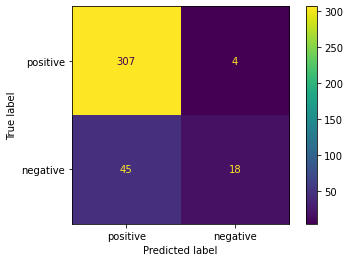

In [98]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative'])
cm_display.plot()
plt.show()

In [ ]:
# Look at # of words per tweet (like # of sentences in nlp lab)??
# if tweet contains product names?
# Try different max_features in vectorizer, max_df, ,in_df
# more ngrams
# Tf-Idf
# balance the targets

Random Forest classifier.

In [99]:
rf = RandomForestClassifier(n_estimators=1000, max_features=5, max_depth=5)
rf.fit(X_t_cv, y_t)
y_hat_rf = rf.predict(X_val_cv)
accuracy_score(y_val, y_hat_rf)

0.8315508021390374